# TP interactomicc EBV HUMAN

In [3]:
import requests
url = "http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/pubid:17446270"

try:
    httpReq = requests.get(url, proxies=None)
except NameError:
    httpReq = requests.get(url)
ans = httpReq.text

In [4]:
ans

'uniprotkb:P0CW72\tuniprotkb:P0CW72\tintact:EBI-2620133|uniprotkb:Q777A5\tintact:EBI-2620133|uniprotkb:Q777A5\tpsi-mi:barf1_ebvg(display_long)|uniprotkb:BARF1(gene name)|psi-mi:BARF1(display_short)|uniprotkb:33 kDa early protein(gene name synonym)|uniprotkb:p33(gene name synonym)\tpsi-mi:barf1_ebvg(display_long)|uniprotkb:BARF1(gene name)|psi-mi:BARF1(display_short)|uniprotkb:33 kDa early protein(gene name synonym)|uniprotkb:p33(gene name synonym)\tpsi-mi:"MI:0397"(two hybrid array)\tCalderwood et al. (2007)\timex:IM-20435|mint:MINT-6769080|pubmed:17446270\ttaxid:10376(ebvg)|taxid:10376("Epstein-Barr virus (strain B95-8)")\ttaxid:10376(ebvg)|taxid:10376("Epstein-Barr virus (strain B95-8)")\tpsi-mi:"MI:0915"(physical association)\tpsi-mi:"MI:0469"(IntAct)\tintact:EBI-2620961|imex:IM-20435-3\tauthor score:+|intact-miscore:0.51\nuniprotkb:P0C704\tuniprotkb:P14348\tintact:EBI-2620975|uniprotkb:Q3KSQ5\tintact:EBI-2620158|uniprotkb:Q777G5|intact:EBI-9645437\tpsi-mi:mcp_ebvg(display_long)|uni

In [6]:
import re

def mitabReader(httpText):
    for line in httpText.split("\n"):
        _ = line.split("\t")
        if len(_) > 1 and _[0].startswith("uniprotkb:")\
                      and _[1].startswith("uniprotkb:"):
            yield [ _[0].replace("uniprotkb:", ""),\
                    _[1].replace("uniprotkb:", "") ]\
                  + _[2:]
                
def isMitab_EBV_EBV(mitabArray):
    reEBV   = "taxid:(1037[6-7]|82830)"
    return re.search(reEBV, mitabArray[9]) and\
       re.search(reEBV, mitabArray[10])

def isMitab_Human_EBV(mitabLine):
    reHuman = "taxid:9606"
    return re.search(reHuman, mitabArray[9]) or\
       re.search(reHuman, mitabArray[10])
        
EBV_EBV_mitab   = []
EBV_Human_mitab = []
total = 0
for mitabArray in mitabReader(ans):
    total += 1
    if isMitab_EBV_EBV(mitabArray):
        EBV_EBV_mitab.append(mitabArray)
    elif isMitab_Human_EBV(mitabArray):
        EBV_Human_mitab.append(mitabArray)
    else : 
        raise ValueError("Je ne connais pas cette espece ==> ", mitabArray[9:11])

print(f"Nombre total d'interactions {total}, EBV-EBV {len(EBV_EBV_mitab)} EBV-Human {len(EBV_Human_mitab)}")

Nombre total d'interactions 230, EBV-EBV 59 EBV-Human 171


In [11]:
ebv_protein = set()
for data in EBV_EBV_mitab:
    ebv_protein.add(data[0])
    ebv_protein.add(data[1])
print(f"{len(ebv_protein)} EBV protein")

human_protein = set()
for data in EBV_Human_mitab:
    human_protein.add(data[0])
    human_protein.add(data[1])

human_protein = human_protein - ebv_protein

print(f"{len(human_protein)} Human protein")

48 EBV protein
129 Human protein


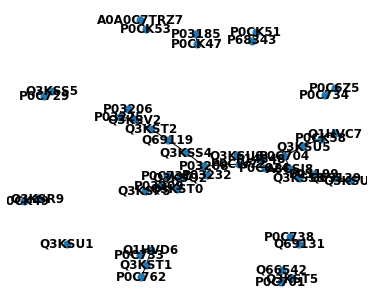

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

import networkx as nx
G = nx.Graph()

plt.figure(figsize=(5, 4))# Set overall figure size

for data in EBV_EBV_mitab:
    p1 = data[0]
    p2 = data[1]
    G.add_edge(p1, p2)

nx.draw(G, with_labels=True, font_weight='bold', node_size=50)
#plt.show()
plt.savefig("EBV_EBV_network.jpeg")

In [26]:
from xml.etree.ElementTree import parse, dump, fromstring, register_namespace, ElementTree

# Utility functions
# 
def goTerms(xmlEntry):
    """Extract the list of GO terms found under provided <entry> xml tag"""
    ns = '{http://uniprot.org/uniprot}'
    goTerms = xmlEntry.findall(ns +'dbReference[@type="GO"]')
    goTermList = []
    for goT in goTerms:
        gID   = goT.attrib['id']
        gName = goT.find(ns +'property[@type="term"]').attrib['value']
        goTermList.append({"name" : gName, "ID" : gID})
    return goTermList

def proteinDict(uniprotID, xmlRoot):
    """Return information about provided UNIPROT accessor as python dictionary"""
    ns   = '{http://uniprot.org/uniprot}'

    data = { "accession" : uniprotID,
             "geneName" : None,
             "name" : None,
             "GOterms" : None
           }

    for entry in xmlRoot.findall(ns+'entry'):
        accessions = entry.findall(ns+"accession")
        for acc in accessions:
            if acc.text == uniprotID: # entry is the node matching provided UNIPROT accessor
                e = entry.find(f"{ns}protein/{ns}recommendedName/{ns}fullName")
                if not e is None:
                    data["name"] = e.text
                e = entry.find(f"{ns}gene/{ns}name") # Corrected xml search for gene tag
                if not e is None:
                    data["geneName"] = e.text

                data["GOterms"] = goTerms(entry)
                return data
    raise ValueError(f"{uniprotID} nor found in XML document")

In [71]:
import re

def geneNameDictFromMitab(mitab, xmlRoot, reTAXID="taxid:(1037[6-7]|82830)"):
    """ Extract geneNames from provided xmlHandler
        It defaults to uniprotID if geneName is not found
        Returns a dict of key,value = UNIPROTID, GeneName || UNIPROTID
    """
    nodeLabels = {}
    for d in mitab:
        for i,uniprotID in enumerate(d[:2]):
            if re.search(reTAXID, d[i + 9]):
                if not uniprotID in nodeLabels:
                    protData = proteinDict(uniprotID, xmlRoot)
                    nodeLabels[uniprotID] = protData['geneName']\
                                             if protData['geneName']\
                                             else uniprotID
    return nodeLabels

tree = parse('./data/Calderwood_EBV_proteome.xml')
root = tree.getroot()
EBV_node_label = geneNameDictFromMitab(EBV_EBV_mitab, root)

tree = parse('./data/Calderwood_Human_proteome.xml')
root = tree.getroot()
EBV_Human_node_label = geneNameDictFromMitab(EBV_Human_mitab, root)


ValueError: Q3KSN9 nor found in XML document

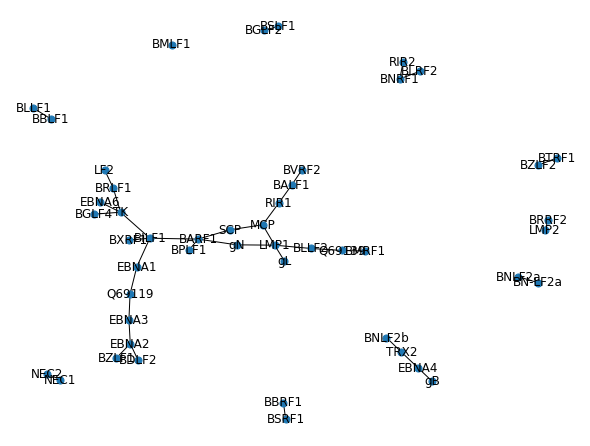

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

import networkx as nx
G = nx.Graph()

plt.figure(figsize=(8, 6))# Set overall figure size

for data in EBV_EBV_mitab:
    p1 = data[0]
    p2 = data[1]
    G.add_edge(p1, p2)
    
G = nx.relabel_nodes(G, EBV_node_label)##
nx.draw(G, with_labels=True, font_weight='light', node_size=50)
plt.show()

In [49]:
EBV_node_label.keys()

dict_keys(['P0CW72', 'P0C704', 'P14348', 'P03185', 'P0CK47', 'P0C731', 'Q3KSQ2', 'P0CK53', 'A0A0C7TRZ7', 'Q3KST5', 'Q66542', 'Q3KSS4', 'P03209', 'Q3KSP5', 'Q3KSU8', 'Q3KSU1', 'Q3KSV2', 'P03206', 'Q3KST2', 'P03225', 'Q3KSU5', 'P0C729', 'Q3KSS5', 'Q69119', 'Q3KST0', 'P0CK58', 'P03208', 'Q69131', 'P0C738', 'P0C701', 'Q1HVC7', 'P0CK49', 'Q3KSR9', 'P0C734', 'P0C6Z5', 'Q3KSS3', 'A8CSJ8', 'P68343', 'P0CK51', 'P03199', 'Q69139', 'P0C6Z4', 'Q3KSU3', 'P03232', 'Q3KST1', 'P0C762', 'P0C733', 'Q1HVD6'])

In [51]:
tree = parse('./data/Calderwood_Human_proteome.xml')
root = tree.getroot()
Human_node_label = {
    # UNIPROTID : GeneName || UNIPROTID   
}
reHuman = "taxid:9606"
for d in EBV_Human_mitab:
     
    uniprotID = d[0] \
        if re.search(reHuman, mitabArray[9])\
        else d[1]

    try:
        protData = proteinDict(uniprotID, root)
    except ValueError as e:
        Human_node_label[uniprotID] = uniprotID
        continue
        
    Human_node_label[uniprotID] = protData['geneName']\
                             if protData['geneName']\
                             else uniprotID
Human_node_label

{'Q3KSN9': 'Q3KSN9',
 'P0C762': 'P0C762',
 'Q8N2S1': 'LTBP4',
 'Q8TAS6': 'LAMB1',
 'P02751': 'FN1',
 'P63010': 'AP2B1',
 'P08670': 'VIM',
 'Q12933': 'TRAF2',
 'P18545': 'PDE6G',
 'Q5T124': 'UBXN11',
 'Q9UBX5': 'FBLN5',
 'P0C701': 'P0C701',
 'Q3KSR8': 'Q3KSR8',
 'P14618': 'PKM',
 'Q49A88': 'CCDC14',
 'Q3KSR7': 'Q3KSR7',
 'A4D0U5': 'TES',
 'P03225': 'P03225',
 'Q1HVD6': 'Q1HVD6',
 'Q9UHV2': 'SERTAD1',
 'Q9NSC5': 'HOMER3',
 'P0CK47': 'P0CK47',
 'P28799': 'GRN',
 'Q96IR5': 'PIGS',
 'Q02818': 'NUCB1',
 'Q12805': 'EFEMP1',
 'P46379': 'BAG6',
 'Q9Y228': 'TRAF3IP3',
 'B2RCM5': 'B2RCM5',
 'Q9UEW3': 'MARCO',
 'A1L0V1': 'ACTN1',
 'Q86V58': 'FBLN2',
 'Q6PKC3': 'TXNDC11',
 'Q9UBP4': 'DKK3',
 'Q93062': 'RBPMS',
 'P03185': 'P03185',
 'Q96NA8': 'TSNARE1',
 'P0CK53': 'P0CK53',
 'O75094': 'SLIT3',
 'Q99873': 'PRMT1',
 'Q96CV9': 'OPTN',
 'Q13576': 'IQGAP2',
 'P0C731': 'P0C731',
 'Q8TF72': 'SHROOM3',
 'O95681': 'XB',
 'P0C736': 'P0C736',
 'P04275': 'VWF',
 'O94813': 'SLIT2',
 'P03208': 'P03208',
 'P03199'

In [54]:
#ebvNodeName

['Q9UBX5',
 'Q3KSN9',
 'Q15723',
 'Q9BRK4',
 'P0C762',
 'Q8N2S1',
 'P28799',
 'Q8TAS6',
 'P02751',
 'P63010',
 'P08670',
 'Q12933',
 'P18545',
 'Q5T124',
 'Q5JY77',
 'P04275',
 'P12814',
 'P0C701',
 'Q9UHV2',
 'A1KXE4',
 'Q9HCE6',
 'Q3KSR8',
 'Q9NRD5',
 'Q96BY9',
 'P14618',
 'Q1HVD6',
 'Q49A88',
 'Q9NSC5',
 'Q3KSR7',
 'Q02818',
 'P03225',
 'A4D0U5',
 'Q13164',
 'P53634',
 'P25788',
 'P61289',
 'O95236',
 'A0A0C7TUY8',
 'P03224',
 'P0CK47',
 'P0CK56',
 'Q96IR5',
 'Q12805',
 'P46379',
 'Q8WXE0',
 'Q9Y228',
 'B2RCM5',
 'Q9UEW3',
 'A1L0V1',
 'Q86V58',
 'P63279',
 'O15162',
 'P55268',
 'Q9UHF1',
 'Q6PKC3',
 'Q9UBP4',
 'Q93062',
 'P03185',
 'Q96NA8',
 'Q9BYM8',
 'P0CK53',
 'O75094',
 'Q99873',
 'Q96CV9',
 'Q71U36',
 'P0C736',
 'P0C731',
 'Q13576',
 'P01857',
 'Q8TF72',
 'O95681',
 'P03208',
 'Q13077',
 'O94813',
 'P20700',
 'P03199',
 'P03200',
 'Q3KSS3',
 'Q3KSU7',
 'Q69132',
 'P0C6Z4',
 'Q8TD31',
 'Q3KSU8',
 'P04233',
 'P49759',
 'P04406',
 'P68871',
 'P04439',
 'P01889',
 'Q86X95',
 'B3KS

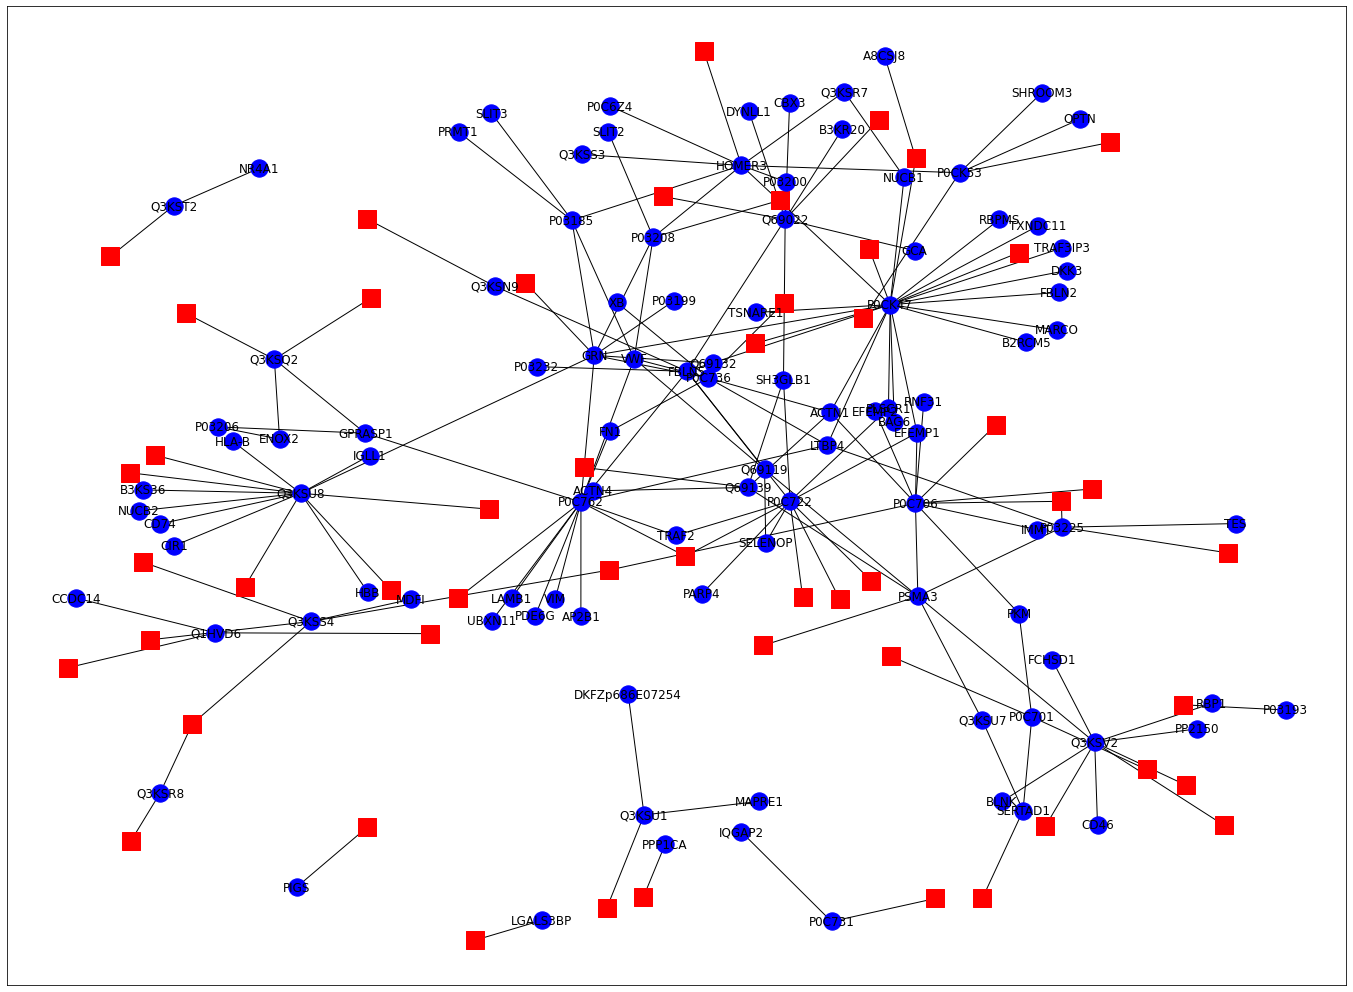

In [60]:
plt.figure(figsize=(24, 18))# Set overall figure size

G = nx.Graph()

for data in EBV_Human_mitab:
    G.add_edge(data[0], data[1])

# get human and ebv node list
humanNodeName = list(Human_node_label.keys())
ebvNodeName   = list( set(list(G.nodes())) - set(humanNodeName) )

# Compute layout then draw on it
pos = nx.spring_layout(G, k=0.22)

# node shapes are registred here : https://matplotlib.org/stable/api/markers_api.html
nx.draw_networkx_nodes(G, pos, ebvNodeName, node_color='red', node_shape='s')
nx.draw_networkx_nodes(G, pos, humanNodeName, node_color='blue', node_shape='o' )
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels=Human_node_label, font_size=12)

plt.show()

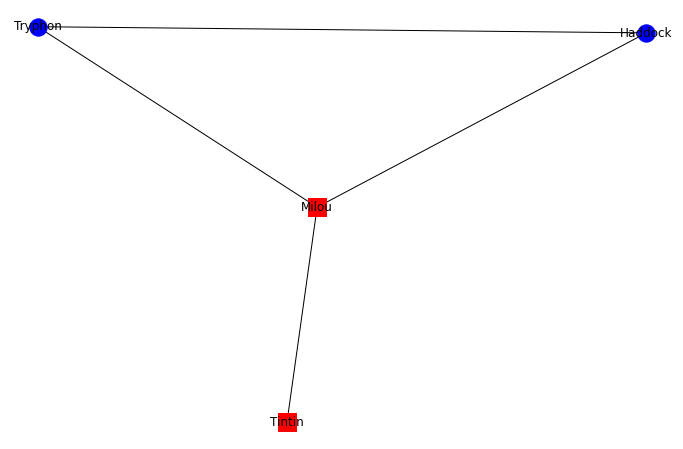

In [83]:
plt.figure(figsize=(12, 8))# Set overall figure size
plt.axis('off')
G = nx.Graph()

for data in [("x", "y"), ("j", "k"), ("y","j"), ("k","y")]:
    G.add_edge(data[0], data[1])
    
name_map = {
    "x" : "Tintin",
    "y" : "Milou",
    "j" : "Tryphon",
    "k" : "Haddock"
}

liste1=["x", "y"]
liste2=["j", "k"]

# Compute layout then draw on it
pos = nx.spring_layout(G)
# node shapes are registred here : https://matplotlib.org/stable/api/markers_api.html
nx.draw_networkx_nodes(G, pos, liste1, node_color='red', node_shape='s')
nx.draw_networkx_nodes(G, pos, liste2, node_color='blue', node_shape='o' )
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels=name_map, font_size=12)
plt.savefig("example_draw.png")
plt.show()